# Data visualization unthrottled:
Unthrottled memory power = ~3000

| # | Setting |
| --- | --- |
| Device | macbook pro 14-inch, 2023 | 
| Chip | Apple M2 Pro | 
| Memory | 16 GB | 
| macOS | 15.1.1 | 
| Java | openjdk 21.0.5 | 
| Node | v23.3.0 | 
| Angular | v18.2.x |

## Core Web Vitals Measurements:

**Long task**
- Task that takes more than 50ms

**TTFB (Time to First Byte):**
 - Time from navigation start until the first byte of response is received
 - Calculated using: performance.getEntriesByType('navigation')[0].responseStart
 
**FCP (First Contentful Paint):**
 - Time when the first text, image, or other content appears on the screen.
 - Is the 'endTime' of the first-contentful-paint
 - FCP includes all things that happened before it (like TTFB).
 
**LCP (Largest Contentful Paint):**
 - Time when the largest text or image element is rendered on the screen (so endTime)
 - Is the 'endTime' of the largest-contentful-paint.
 - FCP includes all things that happened before it (like TTFB).
 
**TTI (Time to Interactive):**
 - Time when the page becomes 'reliably' interactive
 - It is measured as the endtime of the last 'long task' after the FCP starttime
 - If no tasks are found, it is the end-time of the FCP.
 
**TBT (Total Blocking Time):**
 - Sum of all "blocking time" for long tasks between start of FCP and TTI
 - Blocking time = accumulation of (task duration - 50ms) of each long task.
 - TBT contains a 'quiet window' of 5s, if this window is expired, the test will end.
 - The quiet window starts after the FCP. 

In [44]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2f' % x)

csr_dataset = pd.read_csv('../data/results-csr.csv', sep=',')
ssr_dataset = pd.read_csv('../data/results-ssr.csv', sep=',')

datasets =	{
  "ssr": ssr_dataset,
  "csr": csr_dataset,
}

csr_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site         50 non-null     object 
 1   date         50 non-null     object 
 2   time         50 non-null     object 
 3   navTime      50 non-null     int64  
 4   totalTime    50 non-null     int64  
 5   lcp          50 non-null     float64
 6   fcp          50 non-null     float64
 7   ttfb         50 non-null     float64
 8   tbt          50 non-null     int64  
 9   tti          50 non-null     float64
 10  longTasks    50 non-null     int64  
 11  longestTask  50 non-null     int64  
 12  error        0 non-null      float64
dtypes: float64(5), int64(5), object(3)
memory usage: 5.2+ KB


## Comparing the datasets

This table shows the overal metrics of the 2 paradigms and their major differences.

In [45]:
features = ['navTime','totalTime','lcp', 'fcp', 'ttfb', 'tbt', 'longTasks', 'longestTask']
headers = ["feature","dataset","Tests", "min", "1st Qrt.", "mean", "median", "3rd Qrt.", "max", "std dev."] 
report = []

datasets["ssr"].size

for f in features:
  for d in datasets:
    report.append([
        f,
        d,
        datasets[d][f].size,
        datasets[d][f].min(),
        datasets[d][f].quantile(0.25),
        datasets[d][f].mean(),
        datasets[d][f].median(),
        datasets[d][f].quantile(0.75),
        datasets[d][f].max(),
        datasets[d][f].std(),
    ])

pd.DataFrame(report, columns=headers)

,feature,dataset,Tests,min,1st Qrt.,mean,median,3rd Qrt.,max,std dev.
0,navTime,ssr,50,712.00,730.25,746.28,738.50,753.50,1034.00,43.82
1,navTime,csr,50,730.00,762.00,777.92,772.00,781.50,1037.00,44.54
2,totalTime,ssr,50,5723.00,5743.00,5758.28,5749.50,5765.75,6053.00,44.91
3,totalTime,csr,50,5747.00,5775.50,5794.58,5789.00,5798.75,6055.00,44.88
4,lcp,ssr,50,197.30,209.77,238.10,222.25,237.40,783.10,81.34
5,lcp,csr,50,274.40,296.05,313.92,305.20,320.45,571.10,43.27
6,fcp,ssr,50,197.30,206.93,227.11,217.90,222.97,766.50,78.46
7,fcp,csr,50,66.70,83.53,93.59,89.05,100.82,237.70,24.60
8,ttfb,ssr,50,17.10,24.35,32.80,26.15,29.58,317.20,41.34
9,ttfb,csr,50,5.80,9.03,20.27,17.55,25.55,150.80,20.71


The following boxplots will show the outliers and visualizes the overal differences between the paradigms

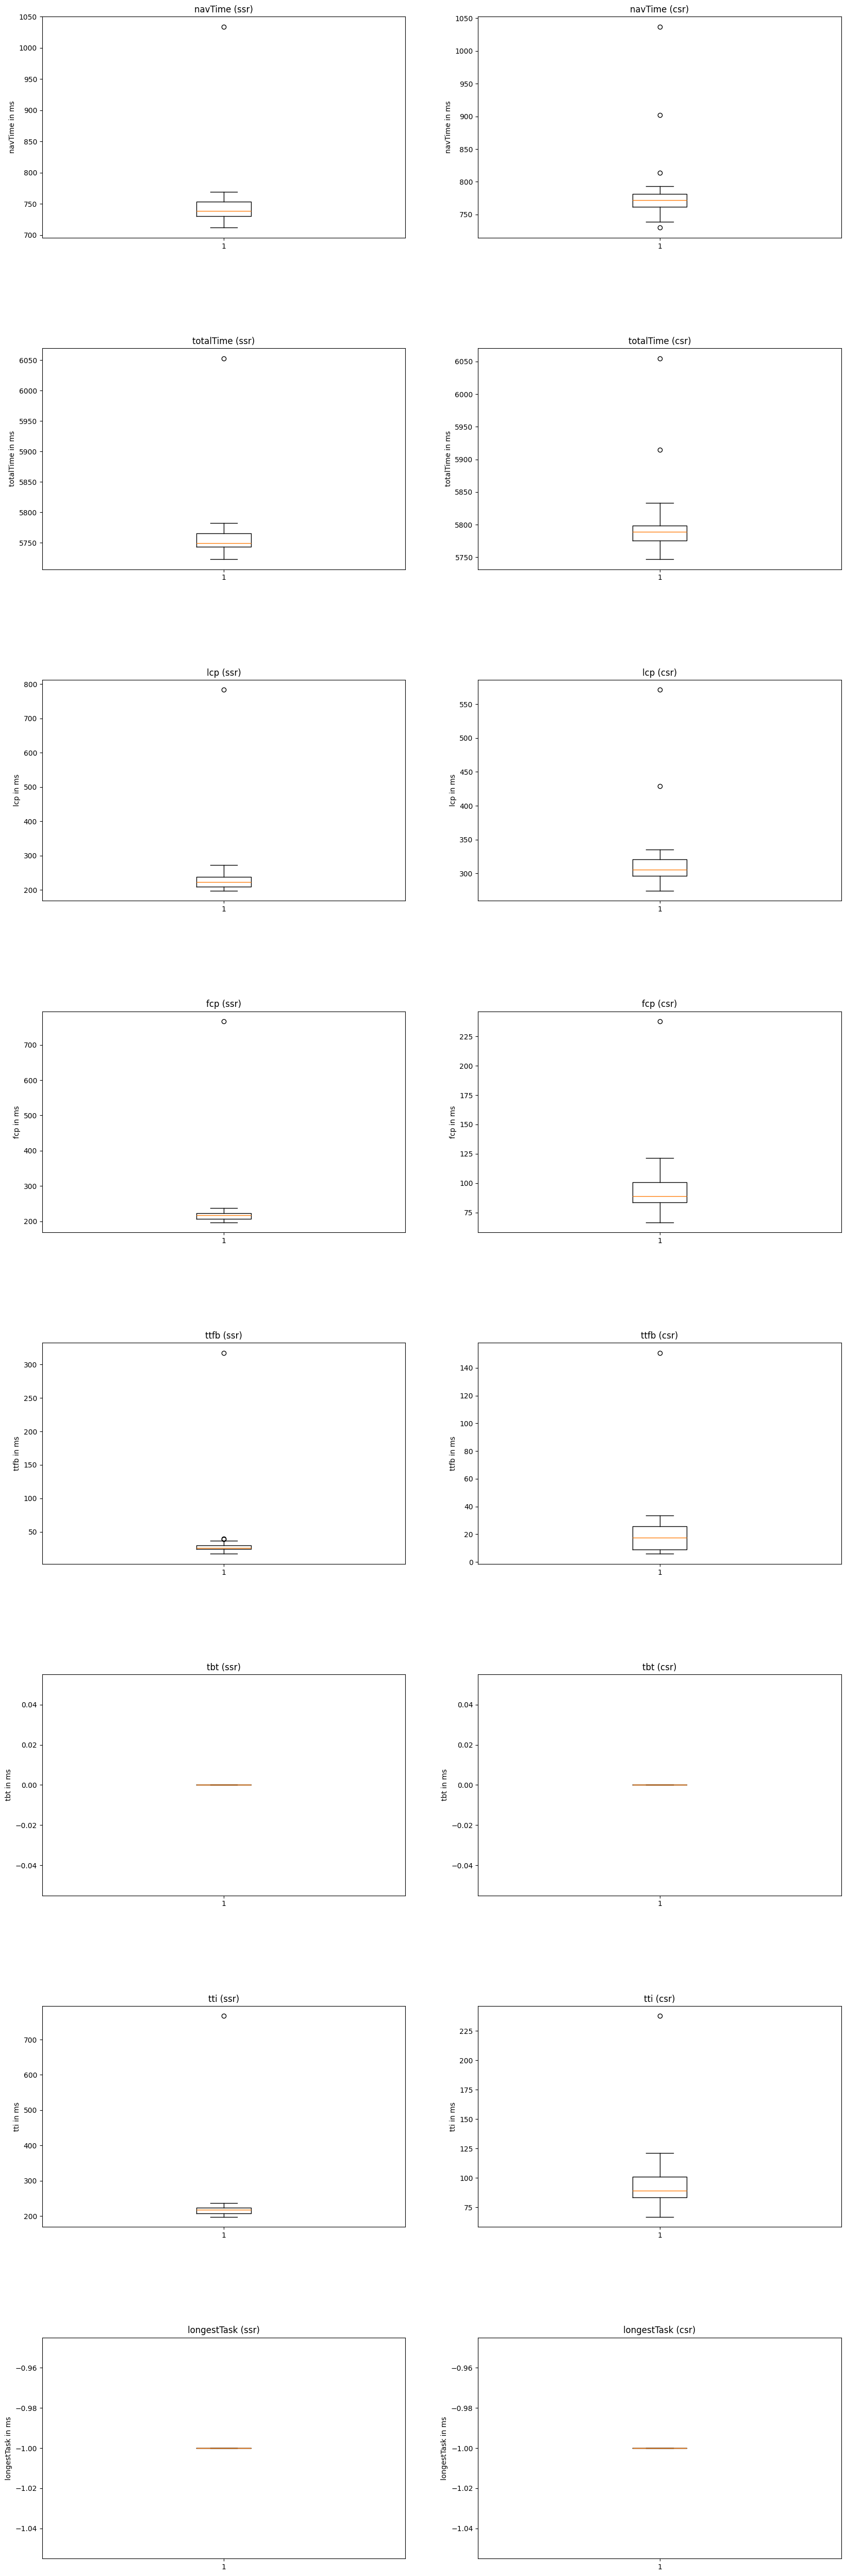

In [46]:
def plot_box_plot(d, f, loc):
    data = datasets[d][f]
    loc.boxplot(data, vert=True)
    loc.set_title(f + ' (' + d + ')')
    loc.set_ylabel(f + ' in ms')

def graphs(plot_func, features, height=8):
    rows = len(features)
    cols = len(datasets)

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_func(d, f, axes[y, x])
    return plt

plt = graphs(plot_box_plot, ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])
plt.show()

<module 'matplotlib.pyplot' from '/Users/auke/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

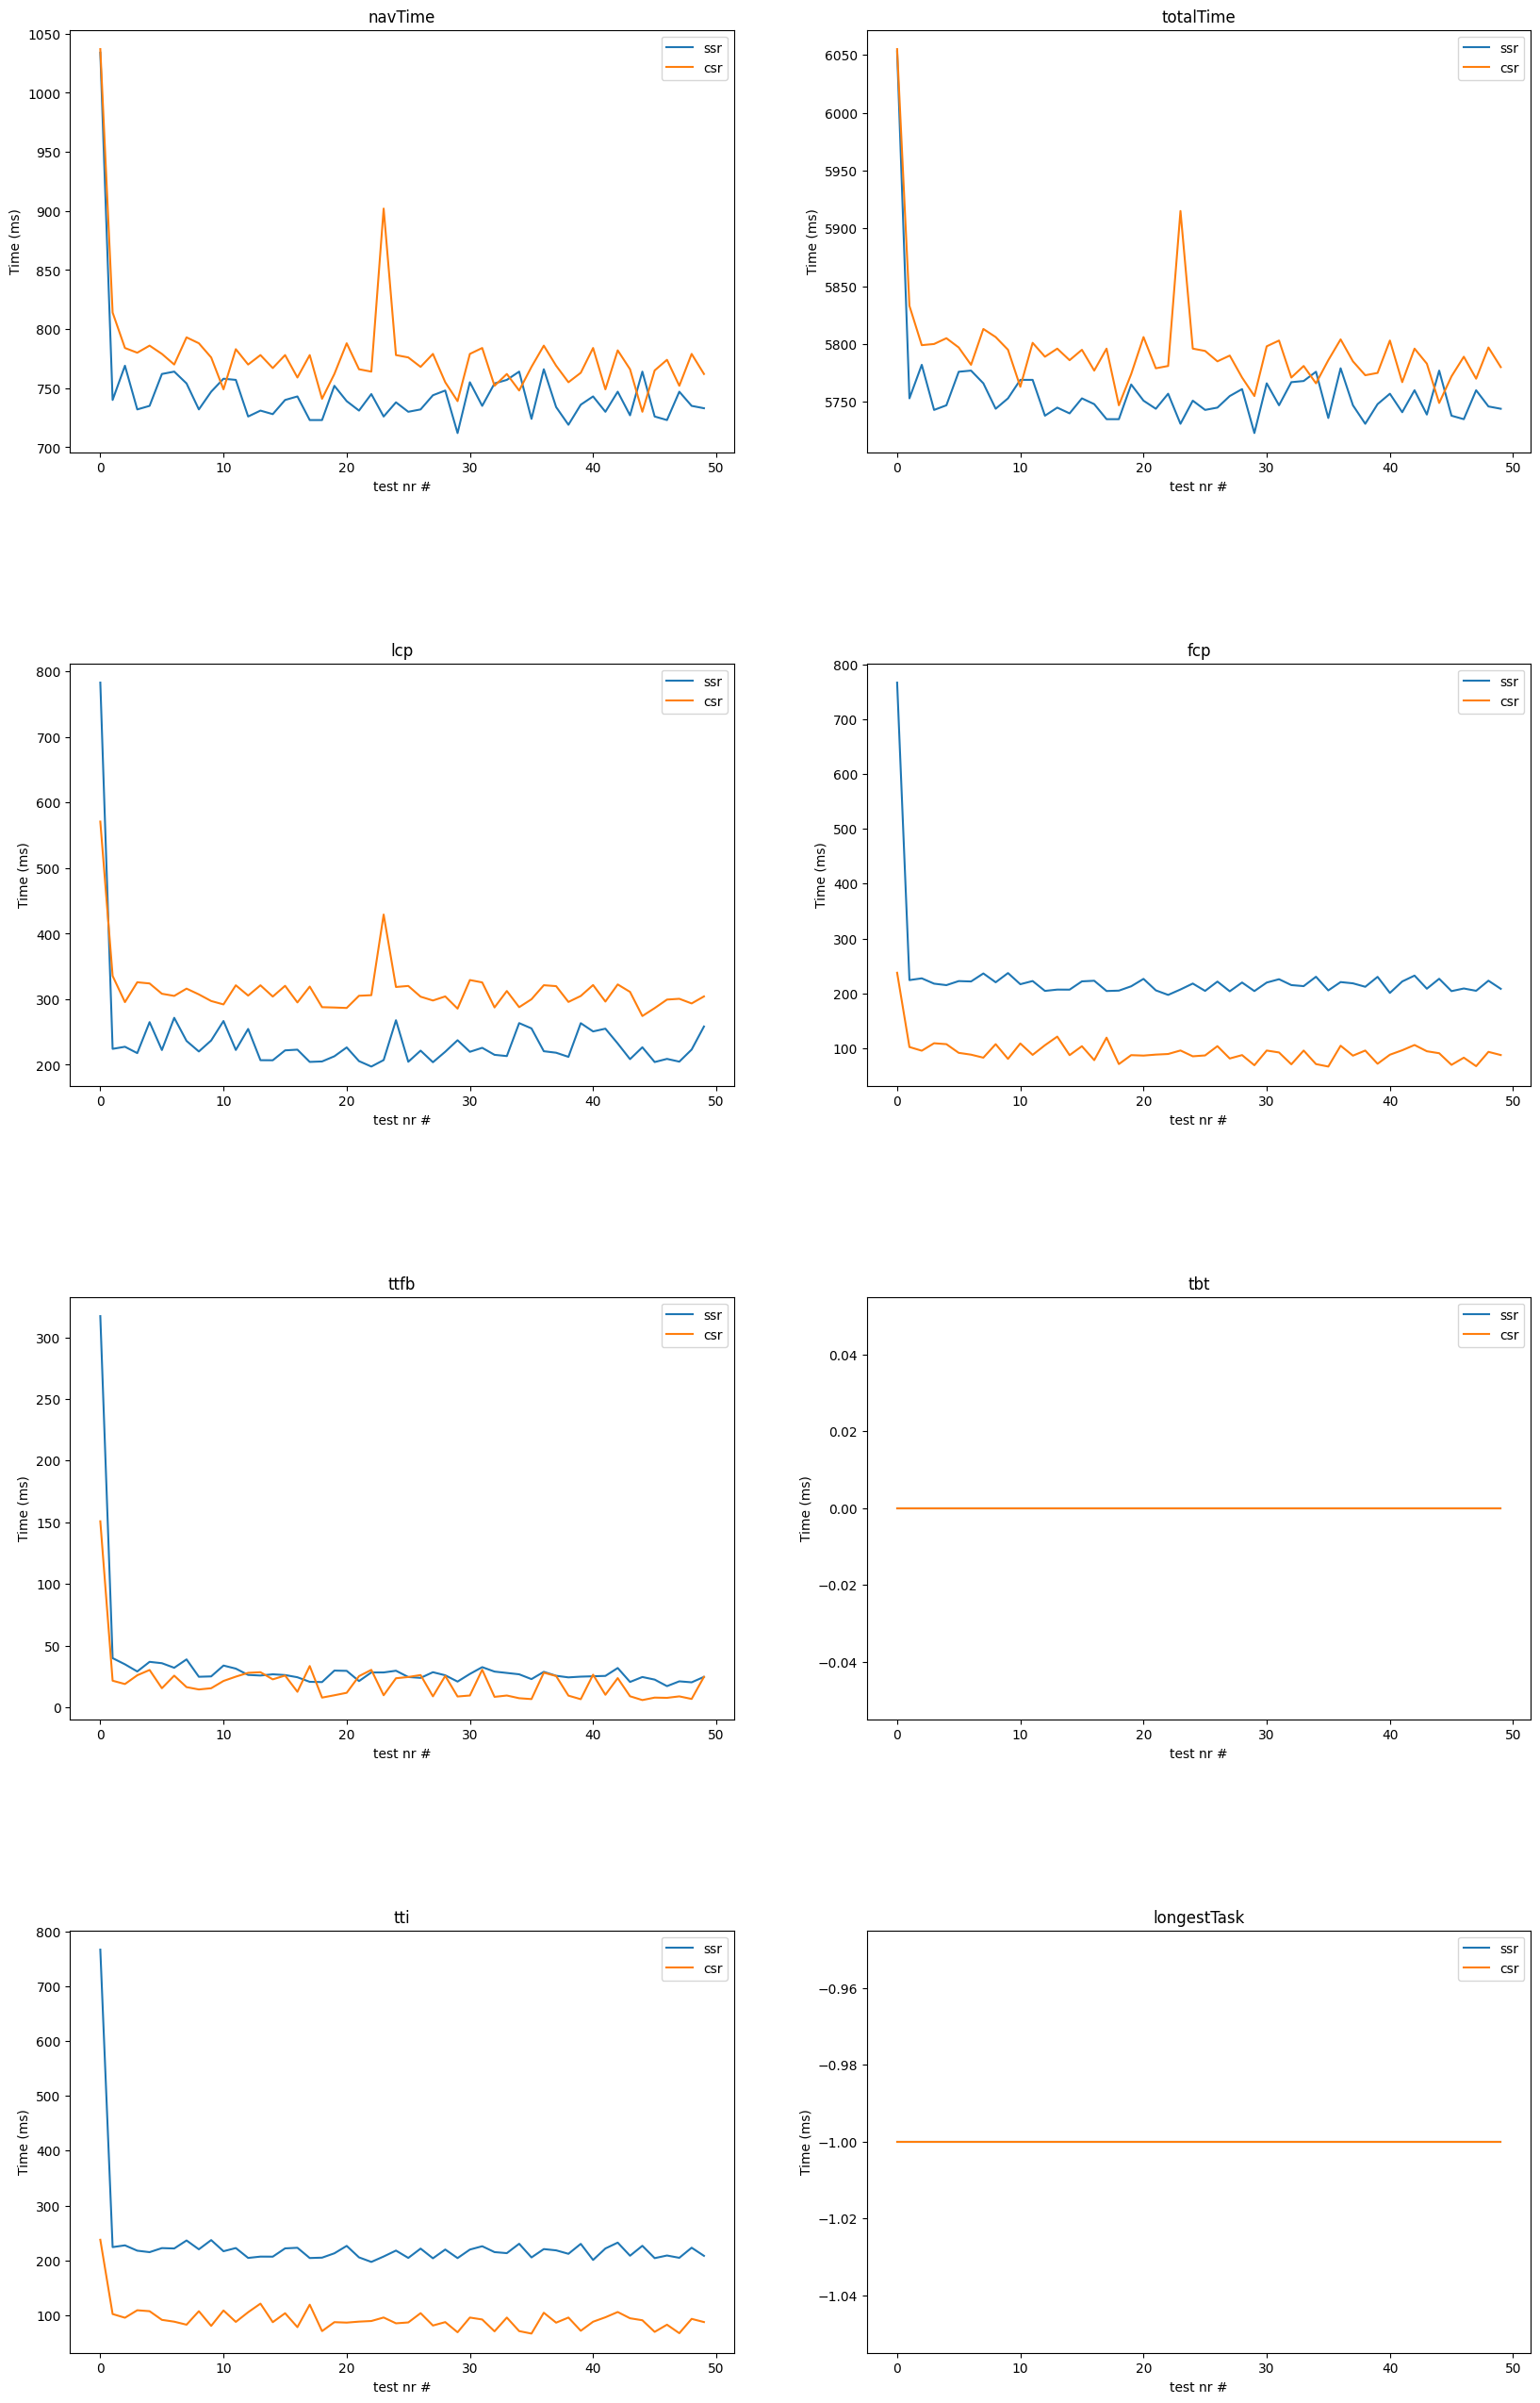

In [47]:
def ceildiv(a, b): return -(a // -b)

def plot_line_graph(feature, loc):
    for d in datasets:
        loc.plot(datasets[d][feature], label=d)
    
    loc.set_title(feature)
    loc.set_ylabel('Time (ms)') 
    loc.set_xlabel('test nr #') 

    loc.legend()
    


def graphs(plot_func, features,cols=2, height=8):
    rows = ceildiv(len(features), cols)
    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for i, feature in enumerate(features):
        loc = axes[i // cols, i % cols] if rows > 1 and cols > 1 else axes[i % cols]
        plot_func(feature, loc)
    return plt

graphs(plot_line_graph, ['navTime','totalTime','lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])

Outliers were removed using IQR (So all the white circles in the boxplots were removed since they represent noise)

In [48]:
# def remove_outliers(df, features):
#     for feature in features:
#         Q1 = df[feature].quantile(0.25)
#         Q3 = df[feature].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
#     return df

def remove_outliers(df, _):
    return df.iloc[5:]

sizes = [["Dataset", "Original size", "Size without outliers", "% removed"]]

# Remove outliers from each dataset
for i, key in enumerate(datasets):
    comparison = [key, len(datasets[key])]
    datasets[key] = remove_outliers(datasets[key], ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'longTasks', 'longestTask'])
    comparison.append(len(datasets[key]))
    comparison.append(100 - ((comparison[2] / comparison[1]) * 100))
    sizes.append(comparison)

pd.DataFrame(sizes)

,0,1,2,3
0,Dataset,Original size,Size without outliers,% removed
1,ssr,50,45,10.00
2,csr,50,45,10.00


## Detailed comparison
The line graphs and box-plots show a more detailed overview of the differences between SSR and CSR

<module 'matplotlib.pyplot' from '/Users/auke/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

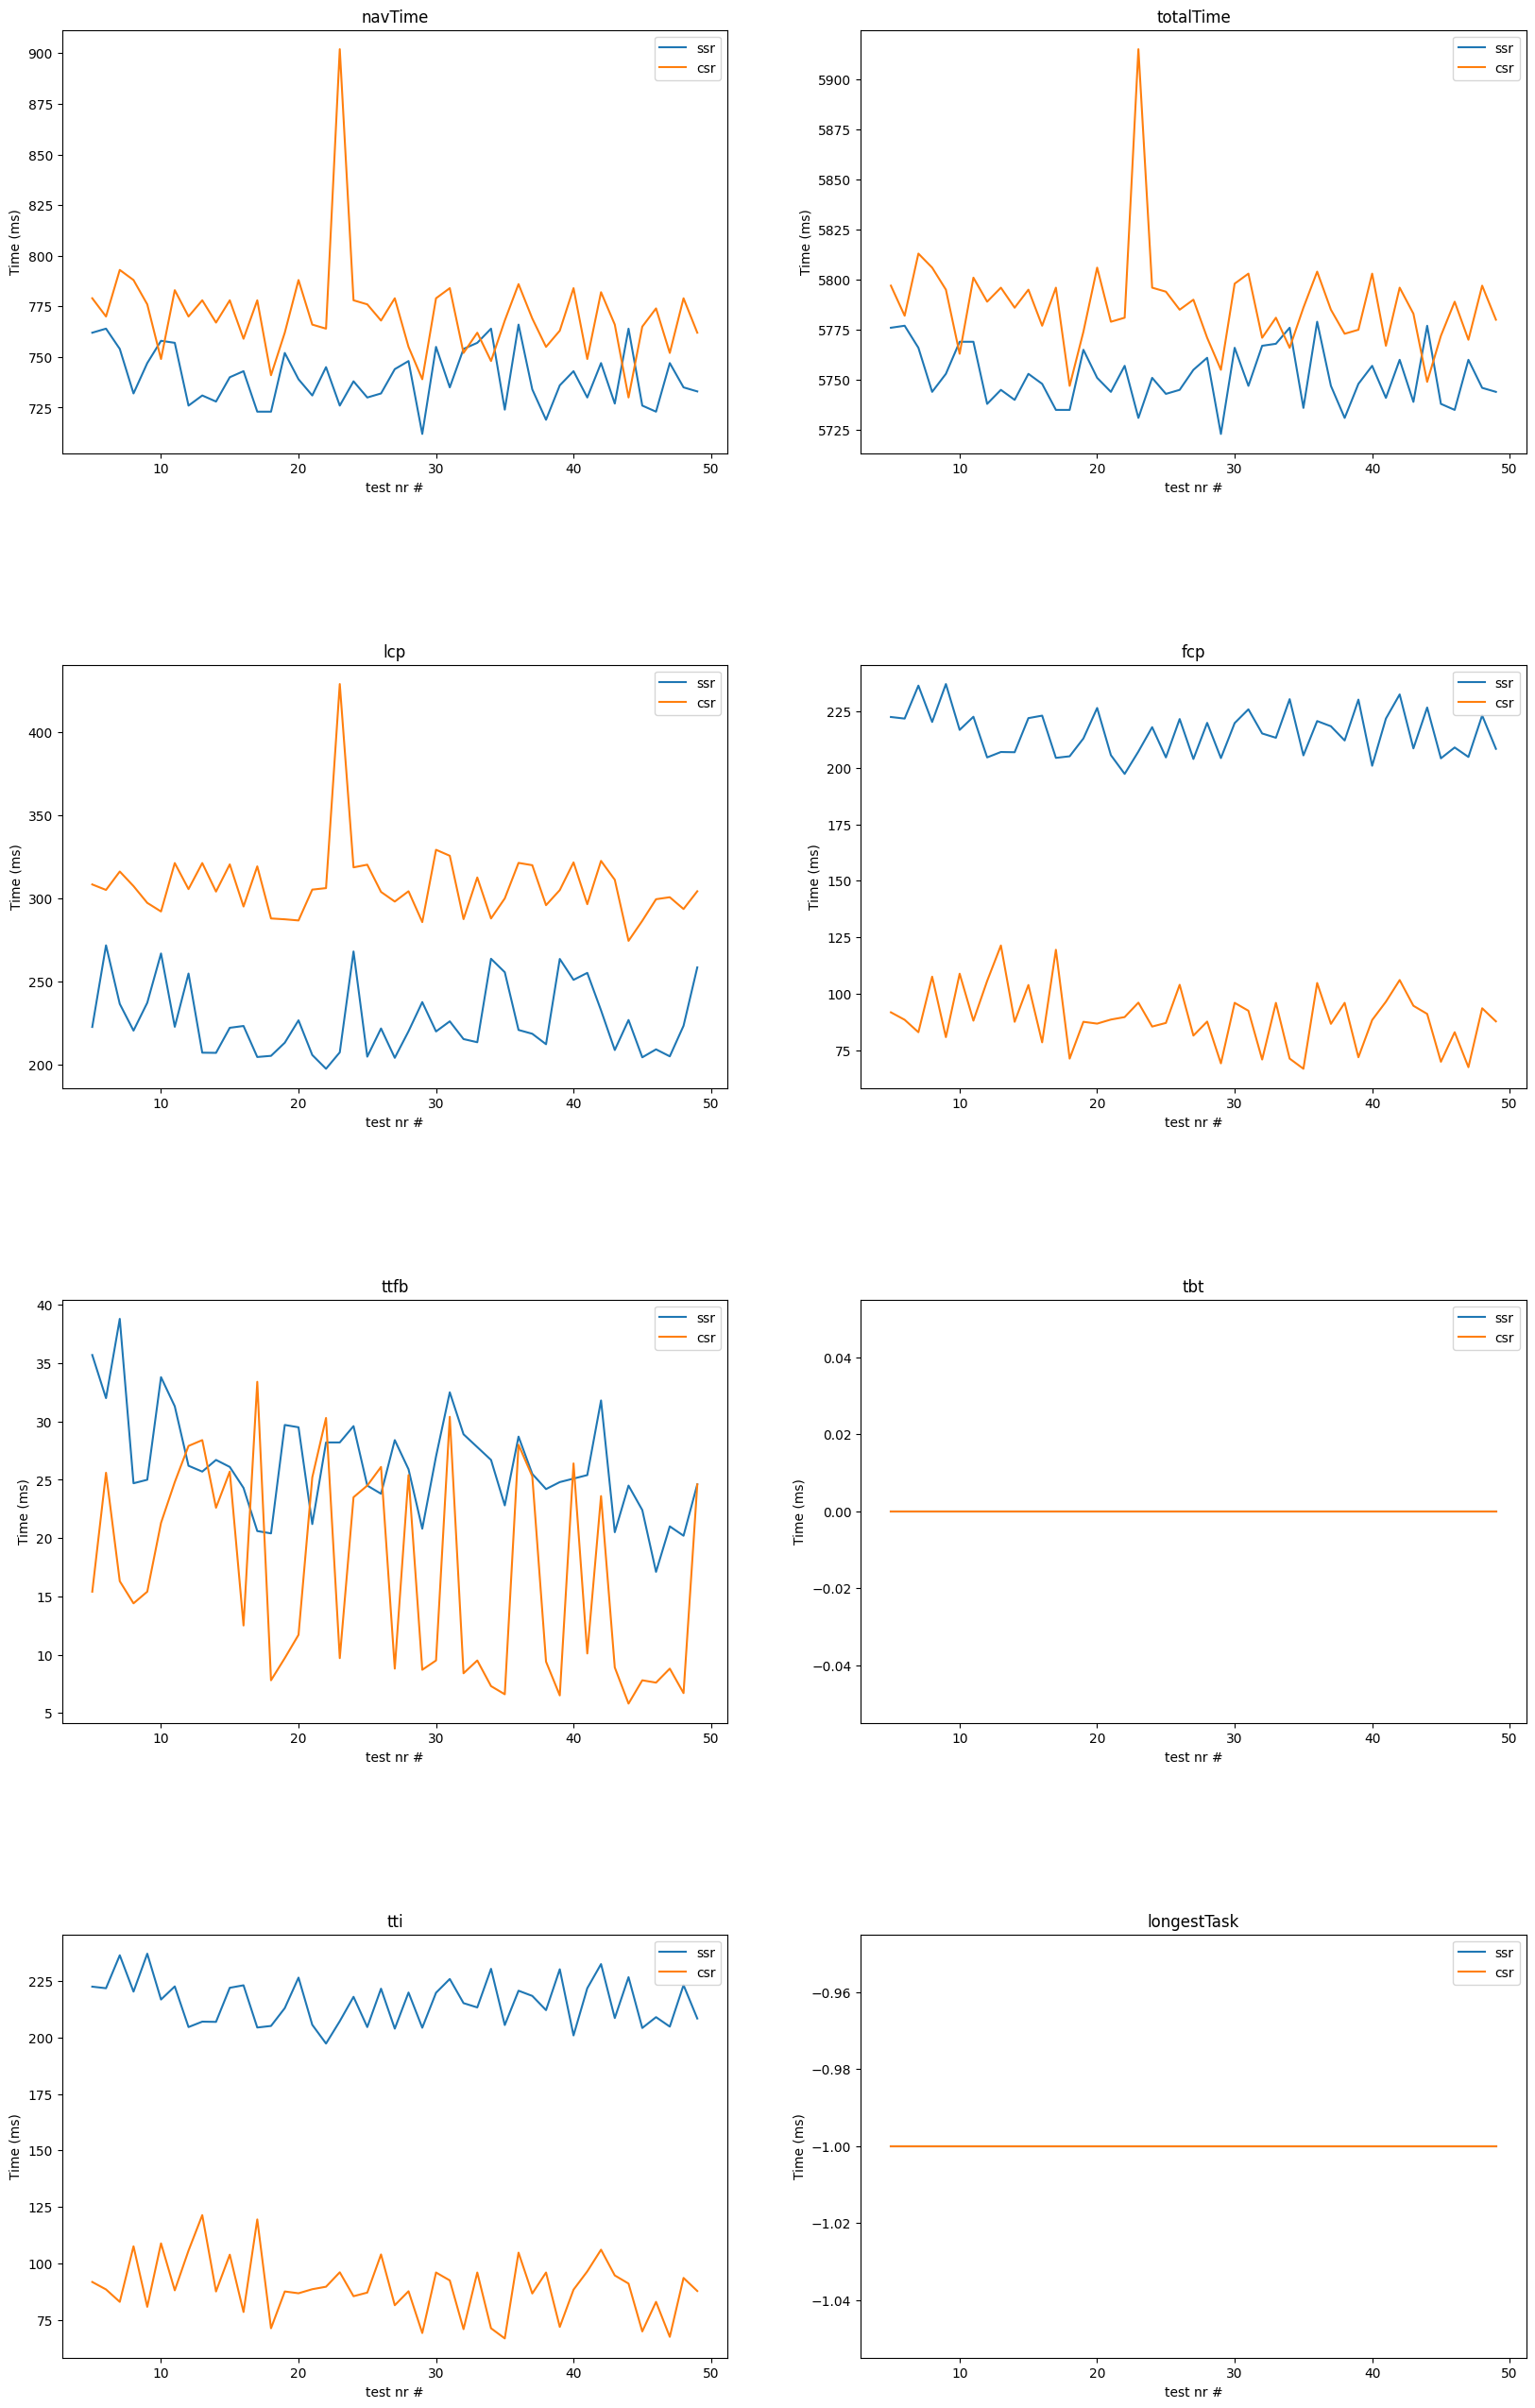

In [49]:
def ceildiv(a, b): return -(a // -b)

def plot_line_graph(feature, loc):
    for d in datasets:
        loc.plot(datasets[d][feature], label=d)
    
    loc.set_title(feature)
    loc.set_ylabel('Time (ms)') 
    loc.set_xlabel('test nr #') 

    loc.legend()
    


def graphs(plot_func, features,cols=2, height=8):
    rows = ceildiv(len(features), cols)
    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for i, feature in enumerate(features):
        loc = axes[i // cols, i % cols] if rows > 1 and cols > 1 else axes[i % cols]
        plot_func(feature, loc)
    return plt

graphs(plot_line_graph, ['navTime','totalTime','lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])

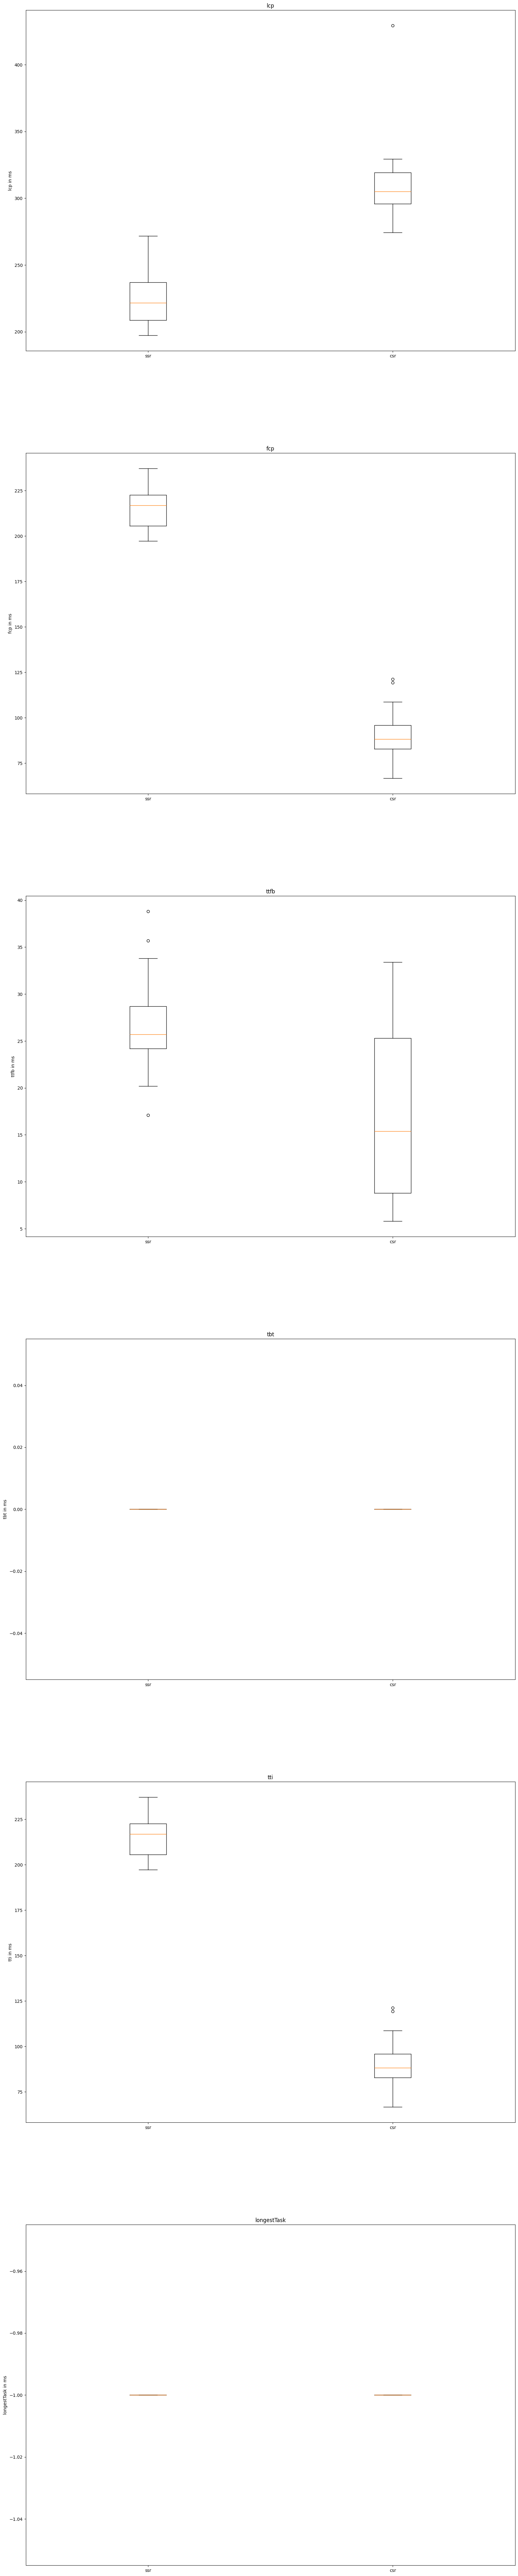

In [50]:
def plot_box_plot(f, loc):
    data = [datasets[d][f] for d in datasets]
    loc.boxplot(data, tick_labels=datasets.keys())
    loc.set_title(f)
    loc.set_ylabel(f + ' in ms')

def graphs(plot_func, features, height=15):
    rows = len(features)
    cols = 1  

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.3, top=0.95, bottom=0.05)  
    for y, f in enumerate(features):
        plot_func(f, axes[y])
    return plt

plt = graphs(plot_box_plot, ['lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])
plt.show()

## Correlations
The scatter charts show the relationships between the metrics and the overal time of the test.

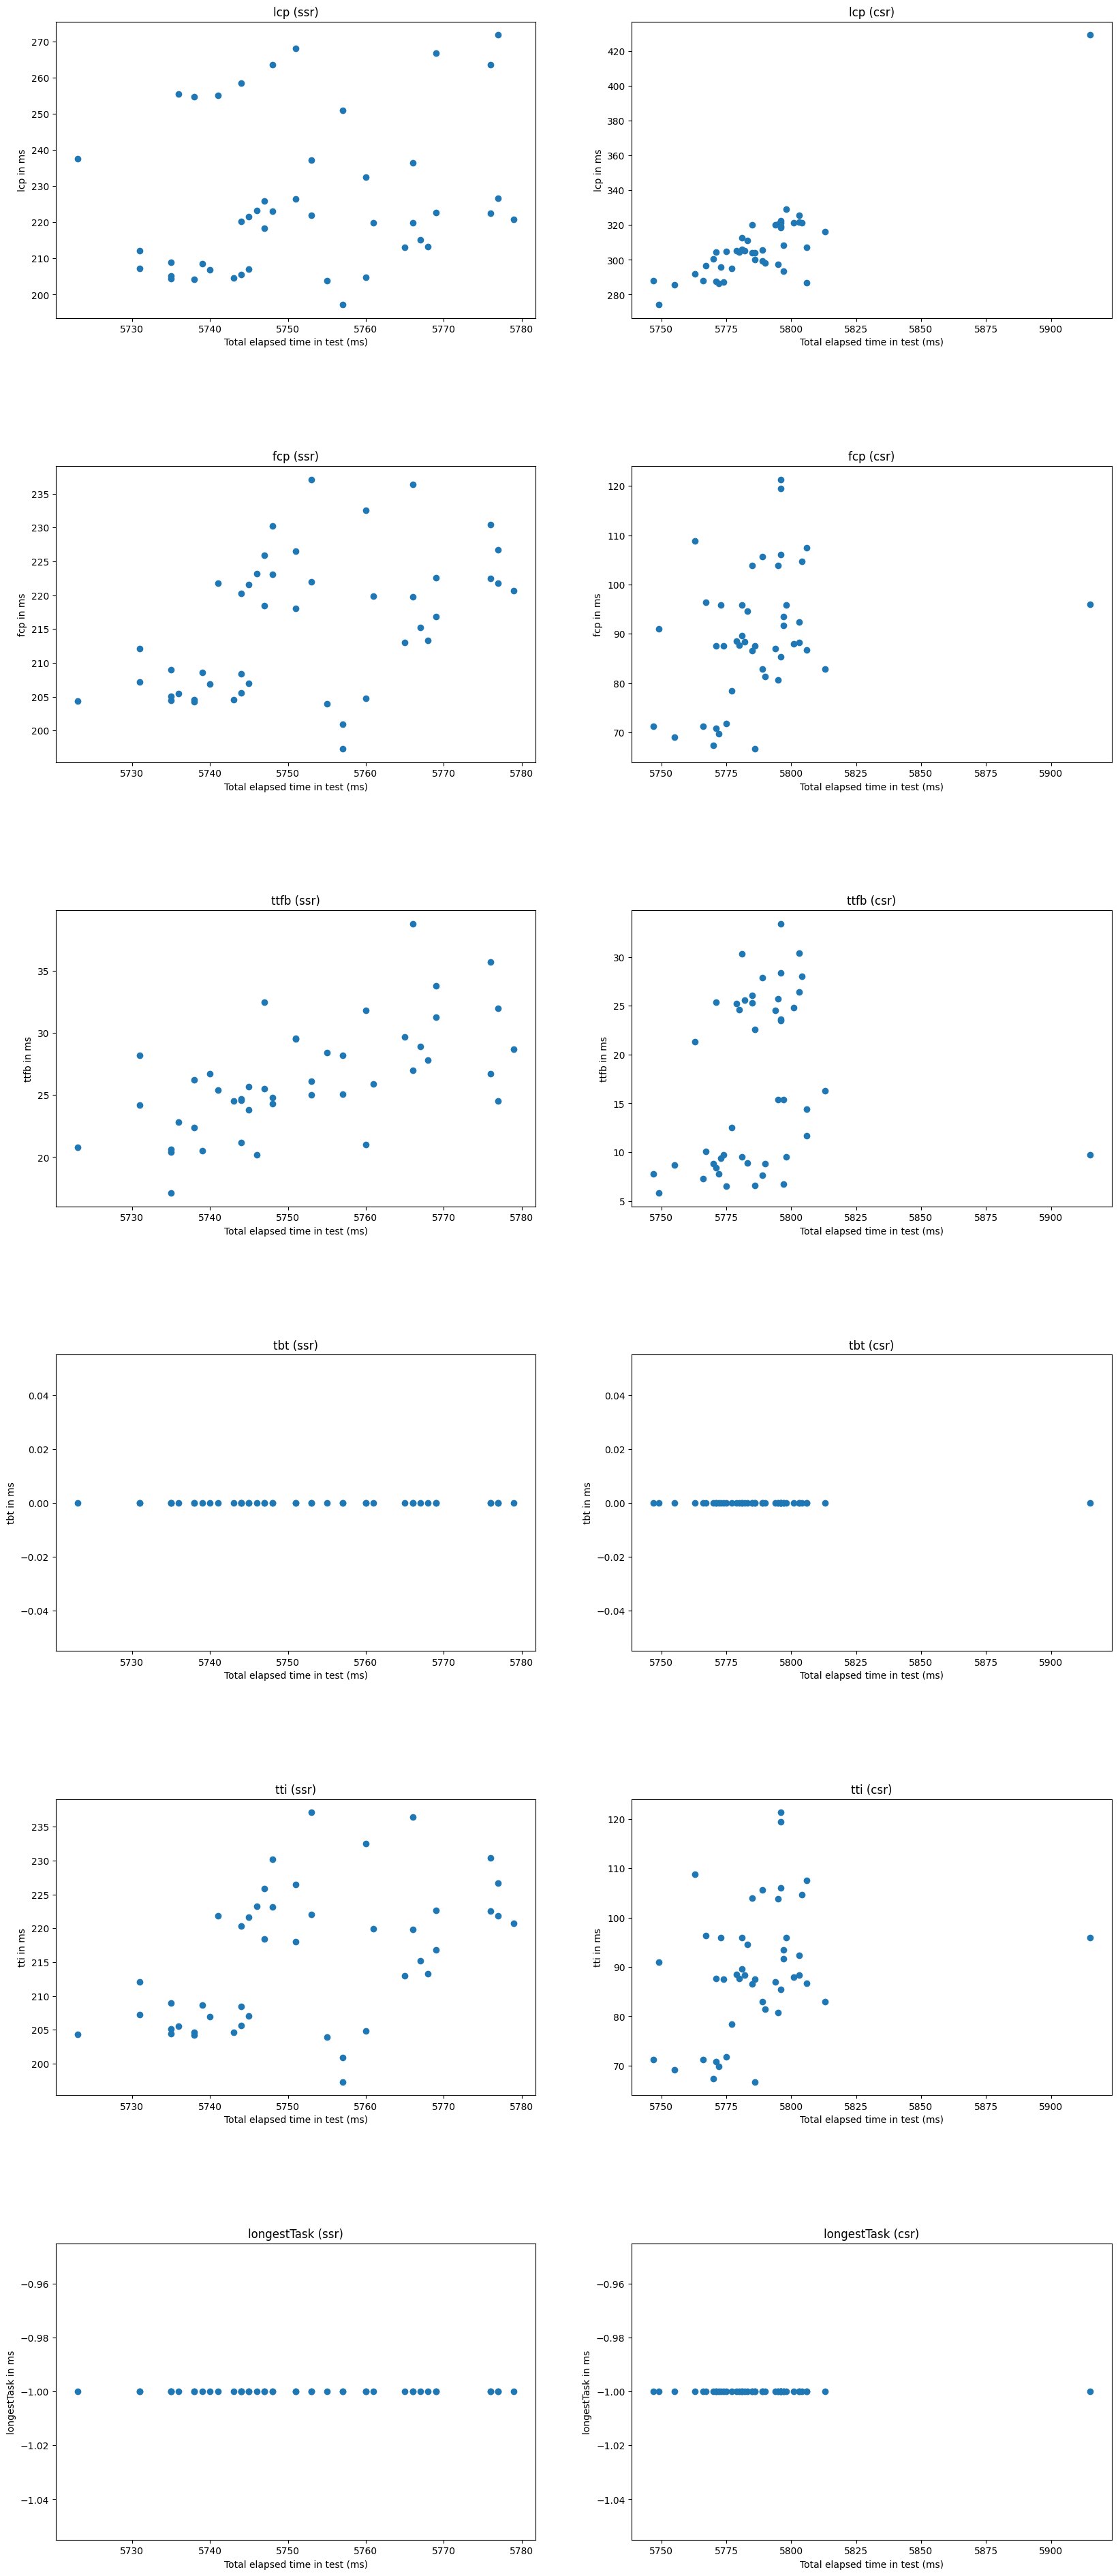

In [51]:
def plot_scatter_plot(d, f, loc):
    loc.scatter(datasets[d]['totalTime'], datasets[d][f], label=d)
    loc.set_title(f + ' (' + d + ')')
    loc.set_xlabel('Total elapsed time in test (ms)')
    loc.set_ylabel(f + ' in ms')

def graphs(plot_func, features, height=8):
    rows = len(features)
    cols = len(datasets)

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_func(d, f, axes[y, x])
    return plt

plt = graphs(plot_scatter_plot, ['lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])
plt.show()


## Frequencies
The histograms show the frequencies of the certain values

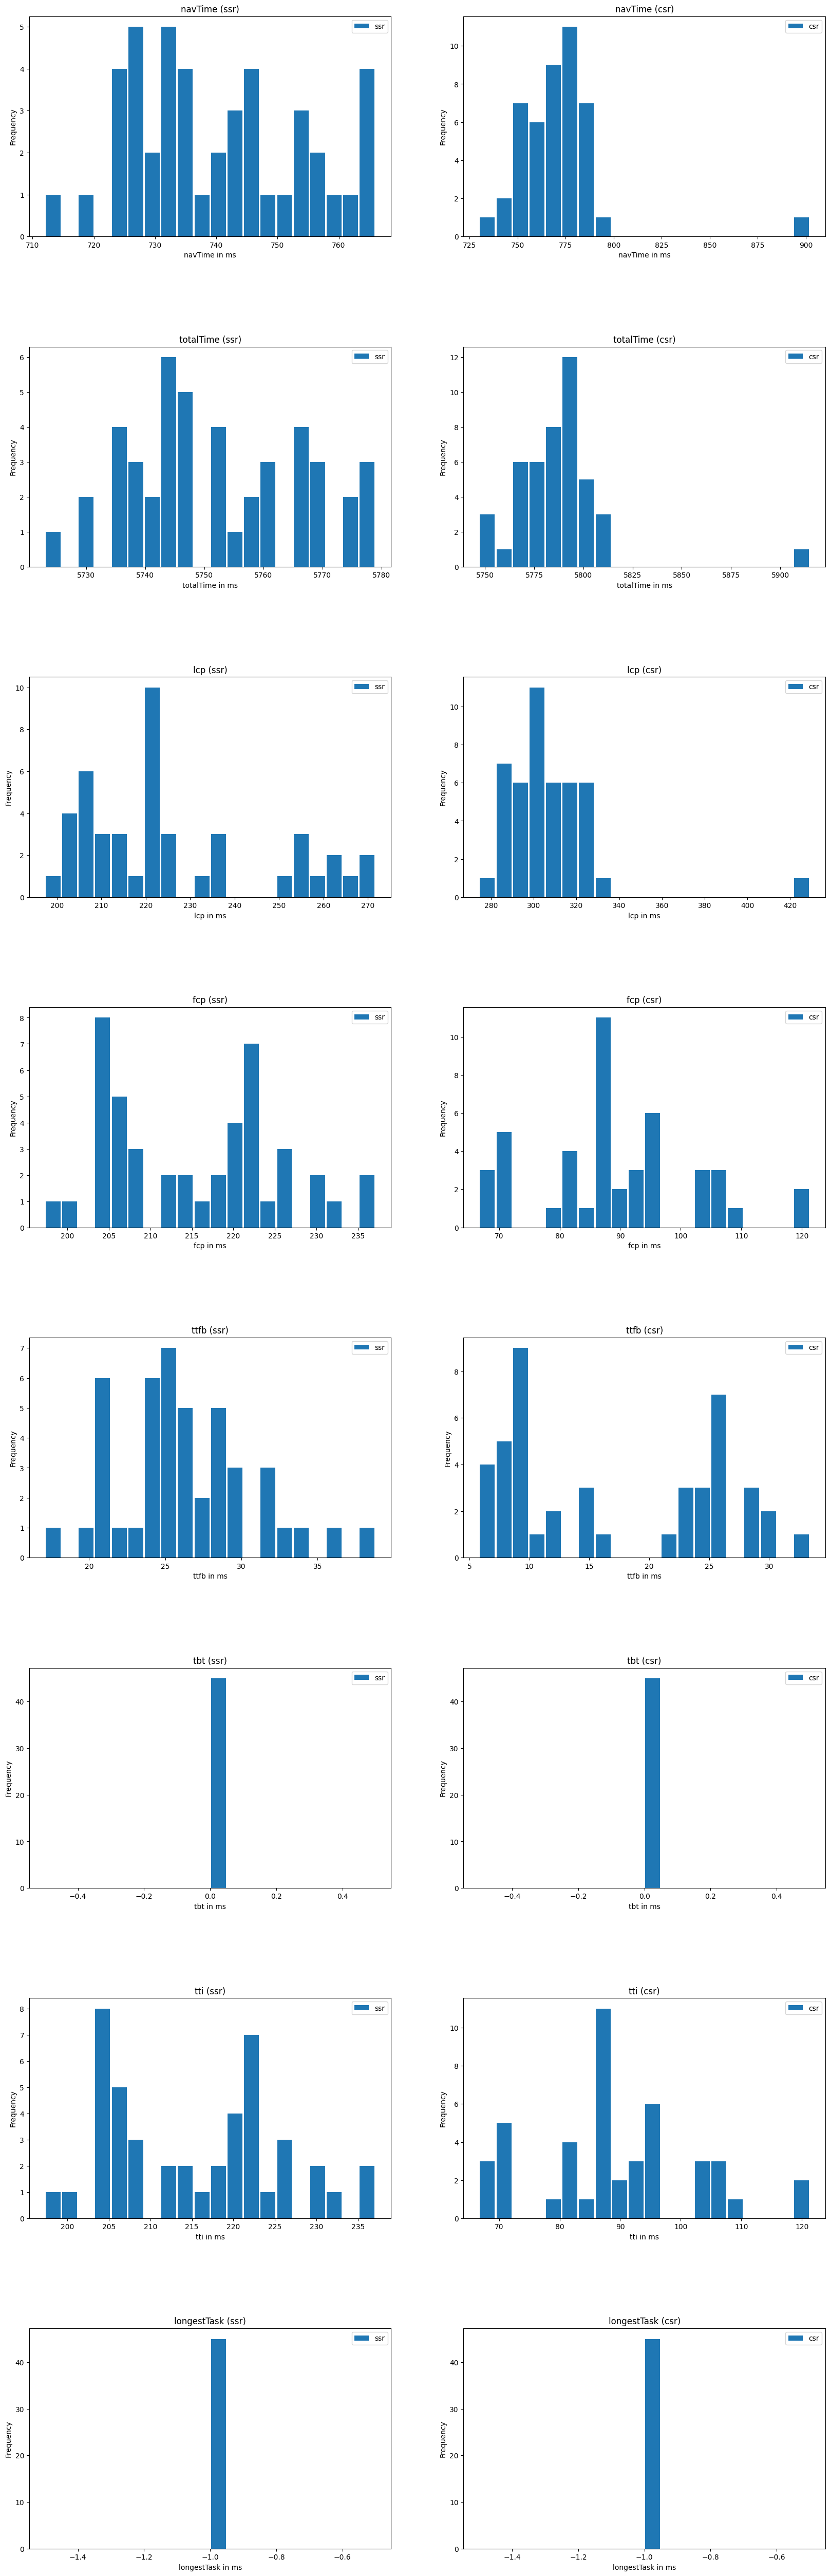

In [52]:
def plot_histogram(d, f, loc):
    data = datasets[d][f].sort_values()
    data.plot(kind='hist', ax=loc, title=f, rwidth=0.9, bins=20)
    loc.set_xlabel(f + ' in ms')
    loc.set_ylabel('Frequency')
    loc.set_title(f + ' (' + d + ')')
    loc.legend([d])

def graphs(plot_func, features,height=8):
    rows = len(features)
    cols = len(datasets)

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_func(d, f, axes[y, x])
    return plt

plt = graphs(plot_histogram, ['navTime','totalTime','lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])
plt.show()